In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
from sstcam_simulation import Camera, SSTCameraMapping, PhotoelectronSource
from sstcam_simulation.plotting import CameraImage
camera = Camera(
    mapping=SSTCameraMapping(n_pixels=8),
    digital_trigger_length=100,
)
pe = PhotoelectronSource(camera=camera, seed=1).get_uniform_illumination(time=100, illumination=1, laser_pulse_width=3)
pe.time[5:] += 50

# Tutorial 3: Event Aquisition - Camera Readout and Trigger

Once you have the photoelectron arrays, the next step is to simulate the camera's response to them. The methods for this are contained within the `EventAcquisition` class. The outputs from these methods can then be used to perform further analysis in order to explore the camera's performance.

In [3]:
from sstcam_simulation.event.acquisition import EventAcquisition
acquisition = EventAcquisition(camera=camera, seed=1)
EventAcquisition?

Init signature: EventAcquisition(camera, trigger=None, seed=None)
Docstring:      <no docstring>
Init docstring:
Collection of methods which simulate operations performed by the camera
electronics for event acquisition (e.g. sampling, trigger,
digitisation), utilising the definitions within the camera container,
and taking in the photoelectron container from the PhotoelectronSource
as input.

Parameters
----------
camera : Camera
    Description of the camera
trigger : Trigger
    Description of the trigger logic
    Default: NNSuperpixelAboveThreshold
seed : int or tuple
    Seed for the numpy random number generator.
    Ensures the reproducibility of an event if you know its seed
File:           ~/Software/sstcam-simulation/sstcam_simulation/event/acquisition.py
Type:           type
Subclasses:     


## Continuous readout

The first simulation involved in the aquisition is to emulate the continous readout from the camera. As continuous readout is complicated to simulate, it is instead emulated with a finely sampled array, with a long length. Any photoelectrons that arrived during this readout are convolved with the reference pulse shape. The electronic noise is also included at this step (if it has been included in the camera configuration).

In [4]:
acquisition.get_continuous_readout?

Signature: acquisition.get_continuous_readout(photoelectrons)
Docstring:
Obtain the sudo-continuous readout from the camera for the given
photoelectrons (signal and background) in this event.

This is built by convolving the reference pulse shape of the camera
with the arrival times and charge of the photoelectrons provided.
Electronic noise is also included at this stage.

The integral of this readout provides the total charge of the
photoelectrons that arrived during the readout (in p.e. units).

Parameters
----------
photoelectrons : Photoelectrons
    Container for the photoelectron arrays, obtained from the EventSimulator

Returns
-------
convolved : ndarray
    Array emulating continuous readout from the camera, with the
    photoelectrons convolved with the reference pulse shape
    Units: photoelectrons / ns
    Shape: (n_pixels, n_continuous_readout_samples)
File:      ~/Software/sstcam-simulation/sstcam_simulation/event/acquisition.py
Type:      method


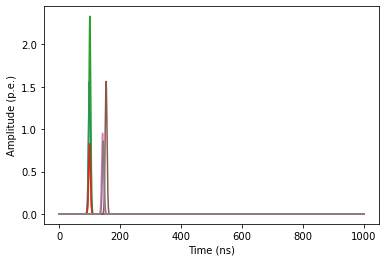

In [5]:
readout = acquisition.get_continuous_readout(pe)
# Divide by photoelectron pulse height to convert sample units to photoelectrons
plt.plot(camera.continuous_readout_time_axis, readout.T / camera.photoelectron_pulse.height)
plt.xlabel("Time (ns)")
_ = plt.ylabel("Amplitude (p.e.)")

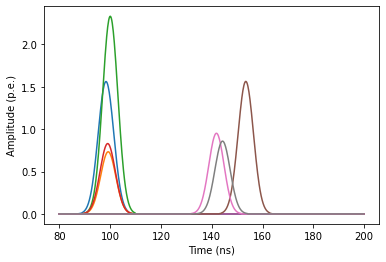

In [6]:
plt.plot(camera.continuous_readout_time_axis[400:1000], readout[:, 400:1000].T / camera.photoelectron_pulse.height)
plt.xlabel("Time (ns)")
_ = plt.ylabel("Amplitude (p.e.)")

## Triggers

The second step is to obtain the trigger times from the continuous readout. This is done by processing the continuous readout through the `Trigger` class provided to `EventAcquisition`. For more details on the logic inside the default `Trigger` class, see tutorial 7_trigger_NNSuperpixelAboveThreshold.

In [7]:
acquisition.get_trigger?

Signature: acquisition.get_trigger(continuous_readout)
Docstring:
Get the triggers generated on the backplane as defined by the Trigger
class

Parameters
----------
continuous_readout : ndarray
    Array emulating continuous readout from the camera
    Shape: (n_pixels, n_continuous_readout_samples)

Returns
-------
trigger_time : ndarray
    Time of coincident rising edges between neighbouring superpixels (ns)
    Shape: (n_triggers)
trigger_pair : ndarray
    The two neighbouring superpixels with coincident digital trigger readouts
    Shape: (n_triggers, 2)
File:      ~/Software/sstcam-simulation/sstcam_simulation/event/acquisition.py
Type:      method


In [8]:
camera.update_trigger_threshold(1)
backplane_triggers = acquisition.get_trigger(readout)

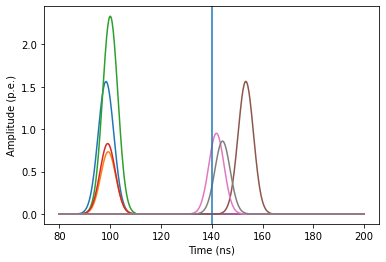

In [9]:
plt.plot(camera.continuous_readout_time_axis[400:1000], readout[:, 400:1000].T / camera.photoelectron_pulse.height)
plt.axvline(backplane_triggers)
plt.xlabel("Time (ns)")
_ = plt.ylabel("Amplitude (p.e.)")

# Waveform Sampling

Once you have a backplane trigger time, you can produce a sampled waveform readout from the camera. The start of the waveform is defined by the trigger time minus the `lookback_time` (configurable in the camera). The waveform length is also defined in the camera.

In [10]:
acquisition.get_sampled_waveform?

Signature: acquisition.get_sampled_waveform(continuous_readout, trigger_time=None)
Docstring:
Sample the continuous readout by integrating over nanosecond bin
widths, to produce a sampled waveform.

The sum of all samples in the waveform provides the total charge that
occurred within the waveform's duration (in p.e. units).

Parameters
----------
continuous_readout : ndarray
    Array emulating continuous readout from the camera
    Shape: (n_pixels, n_continuous_readout_samples)
trigger_time : float
    Time of trigger. Start of waveform is dictated by this time minus
    the lookback time. If None (default), then the start of the readout
    is used as the waveform start.

Returns
-------
waveform : ndarray
    Sampled waveform
    Units: photoelectrons
    Shape: (n_pixels, n_samples)
File:      ~/Software/sstcam-simulation/sstcam_simulation/event/acquisition.py
Type:      method


In [11]:
waveform = acquisition.get_sampled_waveform(readout, backplane_triggers[0])
waveform_time_axis = camera.waveform_time_axis + backplane_triggers[0] - camera.lookback_time

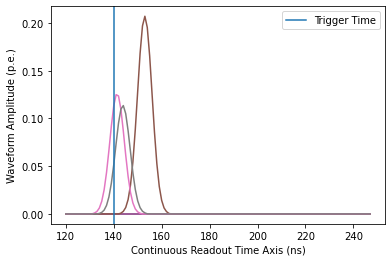

In [12]:
plt.plot(waveform_time_axis, waveform.T)
plt.axvline(backplane_triggers, label="Trigger Time")
plt.xlabel("Continuous Readout Time Axis (ns)")
plt.ylabel("Waveform Amplitude (p.e.)")
plt.legend(loc='best')

Alternatively, one can create a sampled waveform from the start of the coninuous readout (useful when you are doing an investigation that does not require the triggering, e.g. Charge Resolution)

In [13]:
waveform = acquisition.get_sampled_waveform(readout)
waveform_time_axis = camera.waveform_time_axis

Text(0, 0.5, 'Waveform Amplitude (p.e.)')

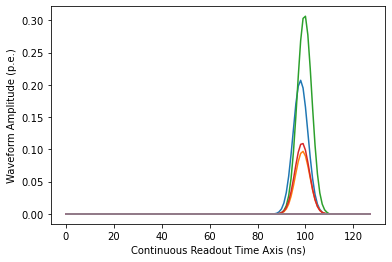

In [14]:
plt.plot(waveform_time_axis, waveform.T)
plt.xlabel("Continuous Readout Time Axis (ns)")
plt.ylabel("Waveform Amplitude (p.e.)")
